In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [3]:
# 1. Colab File Upload

url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [4]:
temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


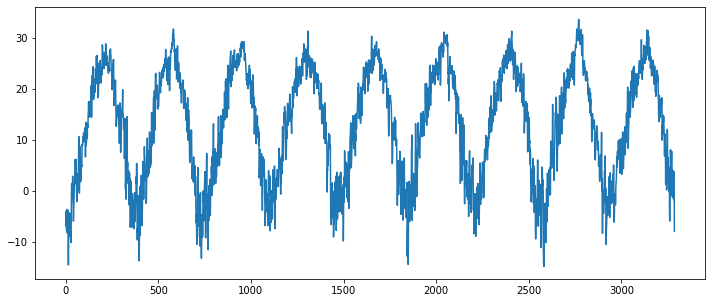

In [5]:
# 2. Data Preprocessing

temp_data = temp[['avg']]

plt.figure(figsize=(12,5))
plt.plot(temp_data)
plt.show()

In [6]:
# tanh Activation 적용을 위해 -1 ~ 1 범위로 Normalization

scaler = MinMaxScaler(feature_range=(-1,1))
temp_data = scaler.fit_transform(temp_data)

In [7]:
# Train_Dataset : 2011.01.01 ~ 2017.12.31
# Test_Dataset : 2018.0101 ~ 2019.12.31

train = temp_data[0:2557]
test = temp_data[2557:]

In [8]:
# 3. 시계열 데이터 처리 함수

# X : 학습 평균온도 데이터
# y : 정답 평균온도 데이터
# 일정 기간의 X 로 y 를 예측하도록 학습

def create_dataset(time_data, look_back=1):
    data_X, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back), 0])
        data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

In [9]:
# 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X, test_y = create_dataset(test, look_back)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180), (2377,), (550, 180), (550,))

In [11]:
# Tensor Reshape

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

In [12]:
# 4. LSTM Modeling

model = Sequential(name = 'LSTM')
model.add(LSTM(64,
               input_shape=(None,1)))
model.add(Dense(1, activation='tanh'))

In [13]:
model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='mse',
              optimizer='adam')

In [15]:
%%time

hist = model.fit(train_X, train_y,
                 epochs=200,
                 batch_size=16,
                 validation_data = (test_X, test_y))

Epoch 1/200
149/149 [==============================] - 13s 39ms/step - loss: 0.0301 - val_loss: 0.0159
Epoch 2/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0169 - val_loss: 0.0156
Epoch 3/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0153 - val_loss: 0.0134
Epoch 4/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0138 - val_loss: 0.0147
Epoch 5/200
149/149 [==============================] - 5s 35ms/step - loss: 0.0131 - val_loss: 0.0119
Epoch 6/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 7/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 8/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 9/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0087 - val_loss: 0.0078
Epoch 10/200
149/149 [==============================] - 5s 36ms/step - loss: 0.00

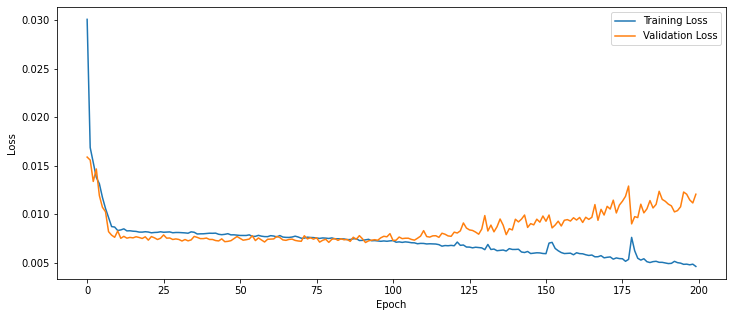

In [18]:
plt.figure(figsize=(12,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [19]:
trainScore = model.evaluate(train_X, train_y, verbose=0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.004381374455988407
Test Score:  0.012054717168211937


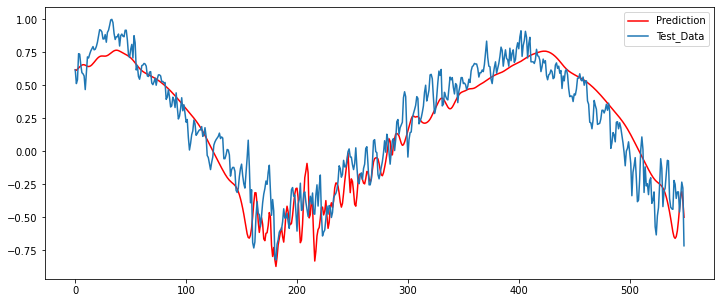

In [20]:
# 5. Model Predict

look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12,5))
plt.plot(np.arange(look_ahead), predictions, 'r', label='Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label='Test_Data')
plt.legend()
plt.show()